# <center> Capstone Project - NLP: Toxic Comment Classification</center>

## Dataset

In [1]:
import numpy as np
import pandas as pd

# For visualizations
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

#Text Preprocessing
import re
import contractions
import unidecode
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet

from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Performance metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data
df = pd.read_csv('train.csv')
print(df.shape)

(159571, 8)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1558,042fe2d289c55264,Esports categories \n\nCan I ask why you moved...,0,0,0,0,0,0
150984,75496eaa06871731,"So do ask a neutral user, but the facts are cl...",0,0,0,0,0,0
109236,482cea72d4035df8,"""\n\n The future of stubs \n\nThere is a propo...",0,0,0,0,0,0
24326,403b092f466ff81c,I don't understand why you want to block me\n\...,0,0,0,0,0,0
157514,df816a35520b5a66,REDIRECT Talk:Death of Dianne Brimble,0,0,0,0,0,0


In [6]:
#check for nulls
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
##new column 'clean'
rowsums=df.iloc[:,2:].sum(axis=1)
df['clean']=(rowsums==0).astype(int)

df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
2962,07ff85cf5090938f,"Welcome!\n\nHello, MyShibboleth, and welcome t...",0,0,0,0,0,0,1
120270,833fd9b29c61487c,"An edit war is determined objectively, not sub...",0,0,0,0,0,0,1
62244,a68b2920f9b5f8a5,"OK, only Anneke Frank is left. I retargeted A...",0,0,0,0,0,0,1
70590,bce62e14894c0d86,Silly me for trying to help.,0,0,0,0,0,0,1
122188,8da8e628588e13fa,HELLO!??? Cretins? Are any of you about? Or ar...,1,0,0,0,1,0,0


## EDA

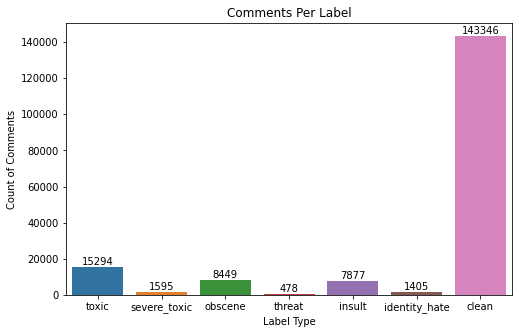

In [22]:
label_counts = df.iloc[:,2:].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(label_counts.index, label_counts.values)
plt.title("Comments Per Category")
plt.ylabel('Count of Comments')
plt.xlabel('Category')

rects = ax.patches
labels = label_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom');

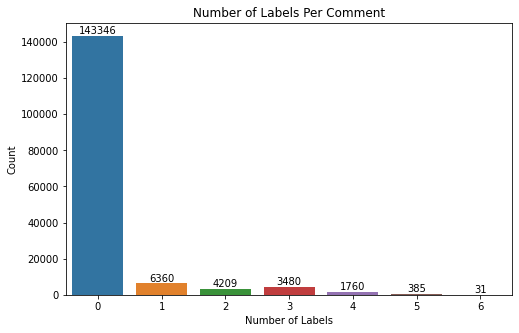

In [21]:
multilabel_count = rowsums.value_counts()

plt.figure(figsize=(8,5))
ax = sns.barplot(multilabel_count.index, multilabel_count.values)
plt.title("Number of Category Per Comment")
plt.ylabel('Count')
plt.xlabel('Number of Category')

rects = ax.patches
labels = multilabel_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom');

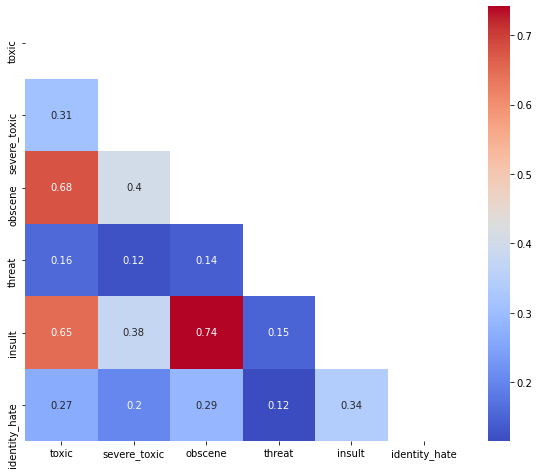

In [24]:
toxic_df=df.iloc[:,2:-1]

matrix = np.triu(toxic_df.corr())

plt.figure(figsize=(10,8))
sns.heatmap(toxic_df.corr(), annot=True, square=True, 
            mask=matrix, cmap= 'coolwarm');

In [5]:
##gets samples for each type of target column
from collections import defaultdict

sample_dict = defaultdict(list)

target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

for i in target_col:
    col_sample = df[df[i]==1]['comment_text'].sample(1).values
    sample_dict[i].append(col_sample)

sample_dict

defaultdict(list,
            {'toxic': [array(['may God spare your soul you are going to hell you worthless piece of shit. Maybe you will have fun when satan is ass fucking u instead of your queer little buddies fuck off and btw kick me off wikipedia you queer ass bitch fuck off and burn in hell bitch!'],
                    dtype=object)],
             'severe_toxic': [array(['"\n\n FUCKER \n\nwhy don\'t you get a real job instead of just looking for things you call ""vandalism"" when in reality it\'s the truth."'],
                    dtype=object)],
             'obscene': [array(["You are such a fucking faggot, there's no need for references for something that can't really be reliably cited. Even if there was a sociological study on people who have APD, coke drinkers, and cocaine users, it wouldn't be very reliable because there's no way to tell if people are lying. Fuck off you beaurocratic official peice of pedophile, and that citing and copyright shit has got to go. I refused t

## Text Preprocessing

In [35]:
def clean_text(raw_text):
    
    #convert all characters to lowercase
    text = raw_text.lower()
    
    #remove http url links
    text = re.sub('http.*.com', '',text)
    
    #remove new line '\n'
    text = re.sub('\n', ' ', text)
        
    #convert accented characters to ASCII characters
    text = unidecode.unidecode(text)
    
    #expand contractions
    text = contractions.fix(text)
    
    # Fix other contractions / possessive
    text = text.replace("'s", '')
    
    #remove special characters and punctuations
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    
    #remove extra white space
    text = re.sub('\s+', ' ', text)
    
    #remove stop words
    cleaned_text = remove_stopwords(text)
    
    return cleaned_text

In [36]:
df['cleaned_text'] = df['comment_text'].apply(lambda x: clean_text(x))

In [43]:
df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,cleaned_text
77849,d0790879ddba4808,"""\n\nFor the record, I am fine with this decis...",0,0,0,0,0,0,1,record fine decision told milo reverting delet...
34504,5c2566272ac70768,"Well, that was an accident. But the article do...",0,0,0,0,0,0,1,accident article meet notability guidelines re...
56690,97762a862df67753,Done. Thanks for the tip.,0,0,0,0,0,0,1,thanks tip
156697,d256016de5f85081,"Thank you \n\nHello Epbr123, I just wanted to ...",0,0,0,0,0,0,1,thank hello epbr123 wanted thank continually b...
159051,f7b7b1ae2ca0ad04,/online.dudley.gov.uk/news/fullrelease.asp?rec...,0,0,0,0,0,0,1,online dudley gov uk news fullrelease asp reci...


### Lemmatization

In [45]:
lemma = WordNetLemmatizer()
  
# Define function to lemmatize each word with its POS tag
  
def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

#apply our functions
df["lemmatized_text"] = df["cleaned_text"].apply(lambda x: lemmatize_doc(x))


In [46]:
df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,cleaned_text,lemmatized_text
101789,20b7d7dec78ca06e,What do you mean by link spam! - These are not...,0,0,0,0,0,0,1,mean link spam bait links valid links resource...,mean link spam bait link valid link resource p...
114339,6390759e9d28c759,Men's movement in India\nI don't believe this ...,0,0,0,0,0,0,1,men movement india believe redirect candidate ...,men movement india believe redirect candidate ...
67829,b5793bd45aaa7278,"""\n\n Category Junk \n\nMae West was many thin...",0,0,0,0,0,0,1,category junk mae west things inappropriate ca...,category junk mae west thing inappropriate cat...
149406,5bc8c06153057784,fuck all wikipedians...(and sinneed)...ah yes ...,1,0,1,0,0,0,0,fuck wikipedians sinneed ah yes returned,fuck wikipedians sinneed ah yes return
65285,aeb03a43c0e522c6,"""\n\nFair use rationale for Image:Loleatta Hol...",0,0,0,0,0,0,1,fair use rationale image loleatta holloway jpg...,fair use rationale image loleatta holloway jpg...


### Unigram

In [48]:
corpus = df.lemmatized_text

tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(corpus)
features = np.array(tfv.get_feature_names())

train_tags=df.iloc[:,2:9]

df_unigrams = tfv.transform(corpus.iloc[:df.shape[0]])

In [56]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [57]:
#get top n for unigrams
tfidf_top_n_unigram=top_feats_by_class(df_unigrams,features)

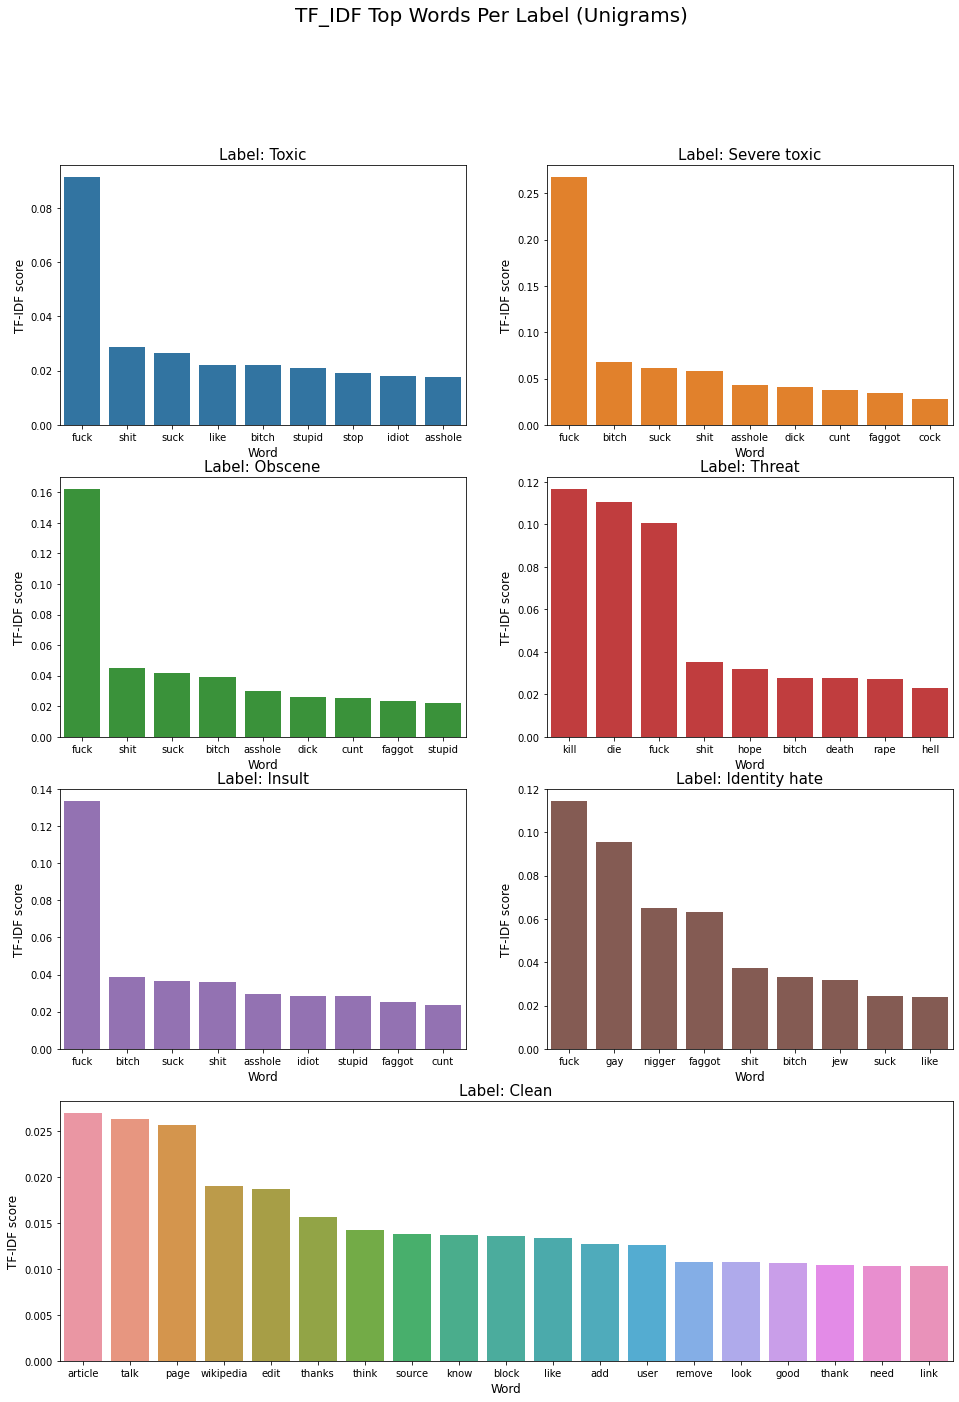

In [68]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top Words Per Label (Unigrams)", fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_unigram[0].feature.iloc[0:9],tfidf_top_n_unigram[0].tfidf.iloc[0:9],color=color[0])
plt.title("Label: Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_unigram[1].feature.iloc[0:9],tfidf_top_n_unigram[1].tfidf.iloc[0:9],color=color[1])
plt.title("Label: Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_unigram[2].feature.iloc[0:9],tfidf_top_n_unigram[2].tfidf.iloc[0:9],color=color[2])
plt.title("Label: Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_unigram[3].feature.iloc[0:9],tfidf_top_n_unigram[3].tfidf.iloc[0:9],color=color[3])
plt.title("Label: Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_unigram[4].feature.iloc[0:9],tfidf_top_n_unigram[4].tfidf.iloc[0:9],color=color[4])
plt.title("Label: Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_unigram[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("Label: Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_unigram[6].feature.iloc[0:19],tfidf_top_n_unigram[6].tfidf.iloc[0:19])
plt.title("Label: Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

### Bigrams

In [63]:
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(corpus)
features = np.array(tfv.get_feature_names())
df_bigrams =  tfv.transform(corpus.iloc[:df.shape[0]])

In [64]:
#get top n for bigrams
tfidf_top_n_bigram=top_feats_by_class(df_bigrams,features)

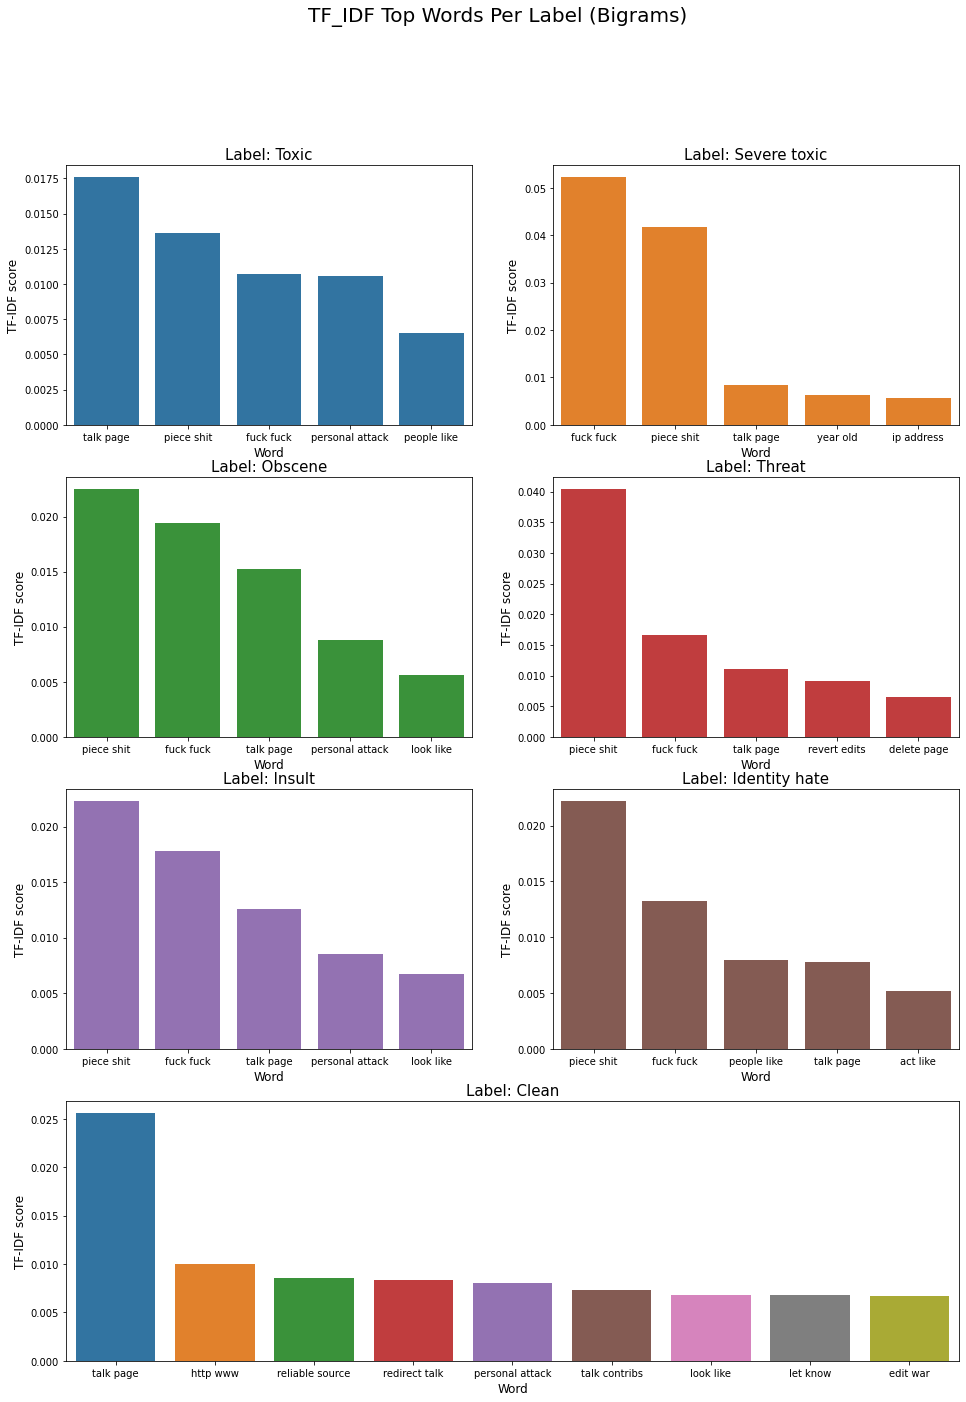

In [65]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top Words Per Label (Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_bigram[0].feature.iloc[0:5],tfidf_top_n_bigram[0].tfidf.iloc[0:5],color=color[0])
plt.title("Label: Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_bigram[1].feature.iloc[0:5],tfidf_top_n_bigram[1].tfidf.iloc[0:5],color=color[1])
plt.title("Label: Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_bigram[2].feature.iloc[0:5],tfidf_top_n_bigram[2].tfidf.iloc[0:5],color=color[2])
plt.title("Label: Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_bigram[3].feature.iloc[0:5],tfidf_top_n_bigram[3].tfidf.iloc[0:5],color=color[3])
plt.title("Label: Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_bigram[4].feature.iloc[0:5],tfidf_top_n_bigram[4].tfidf.iloc[0:5],color=color[4])
plt.title("Label: Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_bigram[5].feature.iloc[0:5],tfidf_top_n_bigram[5].tfidf.iloc[0:5],color=color[5])
plt.title("Label: Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_bigram[6].feature.iloc[0:9],tfidf_top_n_bigram[6].tfidf.iloc[0:9])
plt.title("Label: Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

## Modeling

### Class imbalance: undersample majority class non-toxic

In [69]:
rowsums=df.iloc[:,2:8].sum(axis=1)
df['harmful']=(rowsums!=0).astype(int)

df.harmful.value_counts()

0    143346
1     16225
Name: harmful, dtype: int64

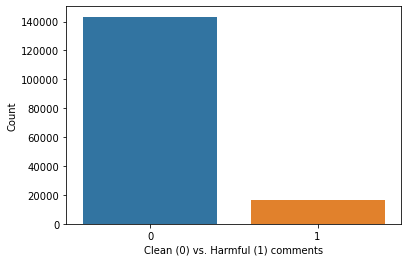

In [22]:
ax = sns.countplot(df['harmful'])
ax.set(ylabel='Count', xlabel='Clean (0) vs. Harmful (1) comments');

In [70]:
# Separate data into harmful comments and non-harmful comments
clean_data = df[df.harmful == 0]
harmful_data = df[df.harmful == 1]

maj_class = clean_data.sample(frac=0.113)

In [71]:
new_df = pd.concat([maj_class, harmful_data], axis=0)

In [72]:
new_df.harmful.value_counts()

1    16225
0    16198
Name: harmful, dtype: int64

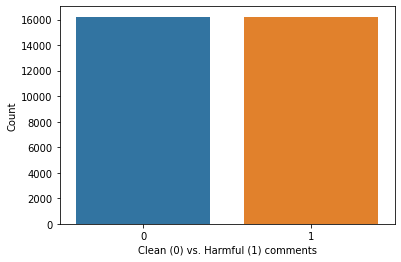

In [73]:
ax = sns.countplot(new_df['harmful'])
ax.set(ylabel='Count', xlabel='Clean (0) vs. Harmful (1) comments');

### Split data into train, test

In [84]:
X = new_df.lemmatized_text.values
y = new_df.harmful.values

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [118]:
# Create list of model and accuracy dicts
list_of_perform = []

# List to keep track of models
models = []

# List to keep track of y_scores
y_scores = []

### Naive Bayes

In [92]:
text_pipe_nb = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

parameters = {'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
              'tfidf__min_df': (0.001,0.01,0.1),\
              'nb__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}

nb_gs = GridSearchCV(text_pipe_nb, parameters, n_jobs=-1, scoring = 'f1')

nb_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05),
                         'tfidf__max_df': (0.75, 0.8, 0.85, 0.9, 0.95, 1.0),
                         'tfidf__min_df': (0.001, 0.01, 0.1)},
             scoring='f1')

In [94]:
print(f'Best params: {nb_gs.best_params_}')

Best params: {'nb__alpha': 0.01, 'tfidf__max_df': 0.75, 'tfidf__min_df': 0.001}


In [97]:
nb_tfidf = nb_gs.best_estimator_

# Calculate accuracy of train
nb_acc = cross_val_score(nb_tfidf, X_train, y_train).mean()
print(f'Accuracy of NB train: {nb_acc}')

# Fit model
nb_tfidf.fit(X_train, y_train)

# Get predictions and probabilities
nb_preds = nb_tfidf.predict(X_test)
nb_y_score = nb_tfidf.predict_proba(X_test)

# Calculate accuracy of test
nb_acc_test = accuracy_score(y_test, nb_preds)
print(f'Accuracy of NB test: {nb_acc_test}')

print()

# Get precision, recall, f1-score
precision, recall, fscore, support = score(y_test, nb_preds, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

Accuracy of NB train: 0.8761018602362493
Accuracy of NB test: 0.8732394366197183

Precision : 0.8733250073824915
Recall    : 0.873292051119875
F-score   : 0.8732386649144657


In [120]:
list_of_perform.append(dict([
    ('Model', 'Naive Bayes'),
    ('Train Accuracy', round(nb_acc, 2)),
    ('Test Accuracy', round(nb_acc_test,2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# Add model to list
models.append('Naive Bayes')

# Add y_score to list
y_scores.append(nb_y_score)

### Logistic Regression

In [105]:
text_pipe_lr = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])

lr_parameters = {'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
             'tfidf__min_df': (0.001,0.01,0.1),\
             'lr__penalty': ('l1','l2'),\
               'lr__C': (0.01, 0.1, 1),\
               'lr__class_weight': (None, 'balanced')}

lr_gs = GridSearchCV(text_pipe_lr, lr_parameters, n_jobs=-1, scoring='f1')

lr_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': (0.01, 0.1, 1),
                         'lr__class_weight': (None, 'balanced'),
                         'lr__penalty': ('l1', 'l2'),
                         'tfidf__max_df': (0.75, 0.8, 0.85, 0.9, 0.95, 1.0),
                         'tfidf__min_df': (0.001, 0.01, 0.1)},
             scoring='f1')

In [106]:
print(f'Best params: {lr_gs.best_params_}')

Best params: {'lr__C': 1, 'lr__class_weight': None, 'lr__penalty': 'l2', 'tfidf__max_df': 0.75, 'tfidf__min_df': 0.001}


In [117]:
lr_tfidf = lr_gs.best_estimator_

# Calculate accuracy of train
lr_acc = cross_val_score(lr_tfidf, X_train, y_train).mean()
print(f'Accuracy of LR train: {lr_acc}')

# Fit model
lr_tfidf.fit(X_train, y_train)

# Get predictions and probabilities
lr_preds = lr_tfidf.predict(X_test)
lr_y_score = lr_tfidf.predict_proba(X_test)

# Calculate accuracy of test
lr_acc_test = accuracy_score(y_test, lr_preds)
print(f'Accuracy of LR test: {lr_acc_test}')

print()

# Get precision, recall, f1-score
precision, recall, fscore, support = score(y_test, lr_preds, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

Accuracy of LR train: 0.8904654521314541
Accuracy of LR test: 0.8890716562146602

Precision : 0.8908464494152264
Recall    : 0.8888559162951789
F-score   : 0.8889020994138794


In [122]:
list_of_perform.append(dict([
    ('Model', 'Logistic Regression'),
    ('Train Accuracy', round(lr_acc, 2)),
    ('Test Accuracy', round(lr_acc_test,2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# Add model to list
models.append('Logistic Regression')

# Add y_score to list
y_scores.append(lr_y_score)

### Random Forest

In [112]:
text_pipe_rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])

rf_parameters = {'tfidf__min_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
             'tfidf__min_df': (0.001,0.01,0.1),\
            'rf__n_estimators': (50, 100, 200),\
                 'rf__criterion': ('gini', 'entropy'),\
               'rf__class_weight': (None, 'balanced')}

rf_gs = GridSearchCV(text_pipe_rf, rf_parameters, n_jobs=-1, scoring='f1')

rf_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__class_weight': (None, 'balanced'),
                         'rf__criterion': ('gini', 'entropy'),
                         'rf__n_estimators': (50, 100, 200),
                         'tfidf__min_df': (0.001, 0.01, 0.1)},
             scoring='f1')

In [113]:
print(f'Best params: {rf_gs.best_params_}')

Best params: {'rf__class_weight': None, 'rf__criterion': 'entropy', 'rf__n_estimators': 200, 'tfidf__min_df': 0.001}


In [124]:
rf_tfidf = rf_gs.best_estimator_

# Calculate accuracy of train
rf_acc = cross_val_score(rf_tfidf, X_train, y_train).mean()
print(f'Accuracy of RF train: {rf_acc}')

# Fit model
rf_tfidf.fit(X_train, y_train)

# Get predictions and probabilities
rf_preds = rf_tfidf.predict(X_test)
rf_y_score = rf_tfidf.predict_proba(X_test)

# Calculate accuracy of test
rf_acc_test = accuracy_score(y_test, rf_preds)
print(f'Accuracy of RF test: {rf_acc_test}')

print()

# Get precision, recall, f1-score
precision, recall, fscore, support = score(y_test, rf_preds, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

Accuracy of RF train: 0.8749124620397086
Accuracy of RF test: 0.8760152153798705

Precision : 0.8795339391070872
Recall    : 0.8757050375772006
F-score   : 0.8756584902118107


In [125]:
list_of_perform.append(dict([
    ('Model', 'Random Forest'),
    ('Train Accuracy', round(rf_acc, 2)),
    ('Test Accuracy', round(rf_acc_test,2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# Add model to list
models.append('Random Forest')

# Add y_score to list
y_scores.append(rf_y_score)

### SVM

In [127]:
text_pipe_svc = Pipeline([('tfidf', TfidfVectorizer()), ('svm', SVC(probability=True))])

svc_parameters = {'tfidf__min_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
             'tfidf__min_df': (0.001,0.01,0.1),\
            'svm__C': (1, 10, 100, 1000),\
                 'svm__degree': (1, 2, 3),\
                 'svm__class_weight': (None, 'balanced')}

svc_gs = GridSearchCV(text_pipe_svc, svc_parameters, n_jobs=-1, scoring='f1')

svc_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': (1, 10, 100, 1000),
                         'svm__class_weight': (None, 'balanced'),
                         'svm__degree': (1, 2, 3),
                         'tfidf__min_df': (0.001, 0.01, 0.1)},
             scoring='f1')

In [128]:
print(f'Best params: {svc_gs.best_params_}')

Best params: {'svm__C': 10, 'svm__class_weight': 'balanced', 'svm__degree': 1, 'tfidf__min_df': 0.001}


In [129]:
svc_tfidf = svc_gs.best_estimator_

# Calculate accuracy of train
svc_acc = cross_val_score(svc_tfidf, X_train, y_train).mean()
print(f'Accuracy of SVC train: {svc_acc}')

# Fit model
svc_tfidf.fit(X_train, y_train)

# Get predictions and probabilities
svc_preds = svc_tfidf.predict(X_test)
svc_y_score = svc_tfidf.predict_proba(X_test)

# Calculate accuracy of test
svc_acc_test = accuracy_score(y_test, svc_preds)
print(f'Accuracy of SVC test: {svc_acc_test}')

print()

# Get precision, recall, f1-score
precision, recall, fscore, support = score(y_test, svc_preds, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

Accuracy of SVC train: 0.8902893571426492
Accuracy of SVC test: 0.8904081422843632

Precision : 0.8915850790395781
Recall    : 0.8902330775761184
F-score   : 0.8902901457716272


In [130]:
list_of_perform.append(dict([
    ('Model', 'Support Vector Classifier'),
    ('Train Accuracy', round(svc_acc, 2)),
    ('Test Accuracy', round(svc_acc_test,2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# Add model to list
models.append('Support Vector Classifier')

# Add y_score to list
y_scores.append(rf_y_score)

### Model Performance

In [131]:
model_perf = pd.DataFrame(data=list_of_perform)
model_perf = model_perf[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
#model_perf.drop_duplicates(inplace=True)
model_perf

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1
0,Naive Bayes,0.88,0.87,0.87,0.87,0.87
1,Logistic Regression,0.89,0.89,0.89,0.89,0.89
2,Random Forest,0.87,0.88,0.88,0.88,0.88
3,Support Vector Classifier,0.89,0.89,0.89,0.89,0.89


In [132]:
def plot_roc_curves():
    plt.figure(figsize=(10,6))
    lw = 2
    
    # Naive Bayes
    fpr, tpr, thresholds = roc_curve(y_test, nb_y_score[:,1], pos_label=1)
    auc_nb = roc_auc_score(y_test, nb_y_score[:,1])
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='NB, auc=%.3f' % auc_nb)
        
    # Logistic Regression
    fpr, tpr, thresholds = roc_curve(y_test, lr_y_score[:,1], pos_label=1)
    auc_lr = roc_auc_score(y_test, lr_y_score[:,1])
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='LR, auc=%.3f' % auc_lr)
        
    # Random Forest
    fpr, tpr, thresholds = roc_curve(y_test, rf_y_score[:,1], pos_label=1)
    auc_rf = roc_auc_score(y_test, rf_y_score[:,1])
    plt.plot(fpr, tpr, color='y',
             lw=lw, label='RF, auc=%.3f' % auc_rf)
    
    # SVC
    fpr, tpr, thresholds = roc_curve(y_test, svc_y_score[:,1], pos_label=1)
    auc_svc = roc_auc_score(y_test, svc_y_score[:,1])
    plt.plot(fpr, tpr, color='chartreuse',
             lw=lw, label='SVC, auc=%.3f' % auc_svc)
    
    # Formatting
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

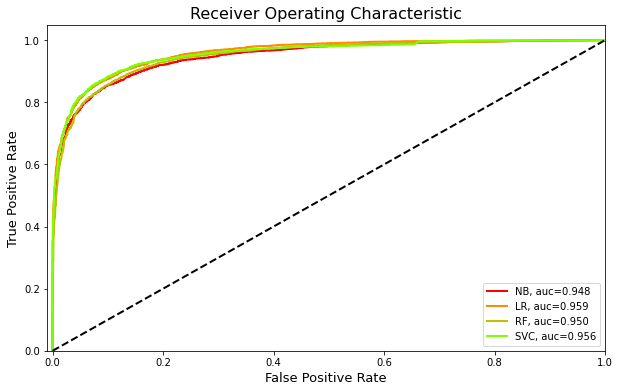

In [133]:
plot_roc_curves()

In [134]:
import pickle

filename = 'lr_model.sav'
pickle.dump(lr_tfidf, open(filename, 'wb'))